In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import xgboost as xgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
%matplotlib inline

In [43]:
df = pd.read_excel('vle_nptc.xlsx')
df.head()

,m1,sigma1,epsilon1,kappa_ab1,epsilon_ab1,NA_1,NB_1,m2,sigma2,epsilon2,kappa_ab2,epsilon_ab2,NA_2,NB_2,x1,T/K,P/Pa,y1,y_exp
0,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.068,373.124,334396.0,0.036339,0.031
1,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.174,373.124,311643.0,0.090161,0.089
2,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.333,373.124,281996.0,0.167015,0.176
3,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.478,373.124,250969.0,0.237391,0.250
4,1.0656,3.0007,366.51,0.034868,2500.7,1,1,1.5255,3.23,188.9,0.035176,2899.5,1,1,0.719,373.124,204774.0,0.381351,0.381


In [44]:
X = df[['m1','sigma1','epsilon1','kappa_ab1','epsilon_ab1','NA_1','NB_1',
        'm2','sigma2','epsilon2','kappa_ab2','epsilon_ab2','NA_2','NB_2',
        'T/K','P/Pa','x1']].values
y = df[['y1']].values

In [45]:
from sklearn.model_selection import train_test_split
X_new,X_val,y_new,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [46]:
best_params =  {'colsample_bylevel': 0.897251399173363, 'colsample_bynode': 0.8073181291974665, 'colsample_bytree': 0.8772125277322299, 'gamma': 0.029664229076429915, 'learning_rate': 0.07830273177800817, 'max_delta_step': 2, 'max_depth': 4, 
            'min_child_weight': 6, 'n_estimators': 203, 'reg_alpha': 0.12145325265378748, 'reg_lambda': 0.42200434284851335, 'subsample': 0.7853398343538209}
xgb_reg = xgb.XGBRegressor(**best_params,random_state = 42,
            objective = 'reg:squarederror', eval_metric=['rmse', 'mae'])
xgb_reg.fit(X_new,y_new,
            eval_set = [(X_val, y_val)],
            verbose=10)

[0]	validation_0-rmse:0.21118	validation_0-mae:0.16594
[10]	validation_0-rmse:0.11965	validation_0-mae:0.09027
[20]	validation_0-rmse:0.08224	validation_0-mae:0.05816
[30]	validation_0-rmse:0.06370	validation_0-mae:0.04396
[40]	validation_0-rmse:0.05606	validation_0-mae:0.03912
[50]	validation_0-rmse:0.05281	validation_0-mae:0.03657
[60]	validation_0-rmse:0.04917	validation_0-mae:0.03378
[70]	validation_0-rmse:0.04757	validation_0-mae:0.03246
[80]	validation_0-rmse:0.04728	validation_0-mae:0.03228
[90]	validation_0-rmse:0.04689	validation_0-mae:0.03208
[100]	validation_0-rmse:0.04638	validation_0-mae:0.03178
[110]	validation_0-rmse:0.04577	validation_0-mae:0.03154
[120]	validation_0-rmse:0.04577	validation_0-mae:0.03153
[130]	validation_0-rmse:0.04535	validation_0-mae:0.03126
[140]	validation_0-rmse:0.04448	validation_0-mae:0.03060
[150]	validation_0-rmse:0.04422	validation_0-mae:0.03043
[160]	validation_0-rmse:0.04421	validation_0-mae:0.03044
[170]	validation_0-rmse:0.04420	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.897251399173363,
             colsample_bynode=0.8073181291974665,
             colsample_bytree=0.8772125277322299, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['rmse', 'mae'], feature_types=None,
             feature_weights=None, gamma=0.029664229076429915, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07830273177800817, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=2,
             max_depth=4, max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=203,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# y_pre_xgb = xgb_reg.predict(X)
# xgb_results_df = pd.DataFrame(y)
# xgb_results_df['y_pred'] = y_pre_xgb

# # 写入 CSV 文件
# xgb_results_df.to_csv('XGBoost_pre_pinn_predictions.csv', index=False)

In [47]:
# import time
# start_time = time.time()
train_leaves = xgb_reg.predict(X_new)
test_leaves = xgb_reg.predict(X_val)
# end_time = time.time()

# run_time = end_time - start_time
# print(f"running time = {run_time} s") 


In [48]:
class MultiOutputModel_3(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size1):
        super(MultiOutputModel_3, self).__init__()
        self.layers = nn.ModuleList()

        
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(prev_size, hidden_size))
            #self.layers.append(nn.BatchNorm1d(hidden_size))  
            self.layers.append(nn.ReLU())
            # self.layers.append(nn.LeakyReLU(negative_slope=0.01))                    
            #self.layers.append(nn.Dropout(p=dropout_p))
            #self.layers.append(nn.Dropout(p=0.2))
            prev_size = hidden_size

        # 输出层
        self.regression_output = nn.Linear(prev_size, output_size1)
        

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        regression_output = self.regression_output(x)
        
        return regression_output

In [49]:
class ConstrainedMSELoss(nn.Module):
    def __init__(self, penalty_weight=1e3, reduction='sum'):
        
        super(ConstrainedMSELoss, self).__init__()
        self.penalty_weight = penalty_weight
        self.reduction = reduction

    def forward(self, y_pred, y_true):
        # 计算标准MSE损失
        mse_loss = nn.functional.mse_loss(y_pred, y_true, reduction='none')
        
        # 计算边界违反惩罚（y_pred超出[0,1]的部分）
        penalty = torch.relu(-y_pred) + torch.relu(y_pred - 1)  # 两部分惩罚：小于0和大于1
        penalty = penalty.sum(dim=-1)  # 沿特征维度求和（若y_pred是多维）

        # 合并损失
        total_loss = mse_loss + self.penalty_weight * penalty

        # 根据reduction参数返回结果
        if self.reduction == 'mean':
            return total_loss.mean()
        elif self.reduction == 'sum':
            return total_loss.sum()
        else:
            return total_loss 

In [50]:
# from sklearn.preprocessing import StandardScaler
# scaler_X = StandardScaler()
# train_leaves_np = train_leaves.reshape(-1,1)
# test_leaves_np = test_leaves.reshape(-1,1) 
# train_leaves_scaled = scaler_X.fit_transform(train_leaves_np)
# test_leaves_scaled = scaler_X.transform(test_leaves_np)

train_leaves = torch.FloatTensor(train_leaves)
y_new = torch.FloatTensor(y_new)
test_leaves = torch.FloatTensor(test_leaves)
y_val = torch.FloatTensor(y_val)

In [ ]:
import optuna
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
def objective(trial):
    # Define hyperparameter search space
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)  # 1 to 5 hidden layers
    hidden_sizes = [
        trial.suggest_int(f'hidden_size_{i}', 4, 64, step=4)  # Units in each layer (16 to 256)
        for i in range(num_hidden_layers)
    ]
    learning_rate = 1e-4
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])  # Batch size
    penalty_weight = 1000
    
    #optimizer_name = trial.suggest_categorical('optimizer', ['Adam'])  # Optimizer type

    # Model parameters (adjust based on your dataset)
    input_size = y_new.shape[1]  # Number of input features
    output_size1 = y_val.shape[1]  # Number of output features

    # Initialize model
    model = MultiOutputModel_3(input_size, hidden_sizes, output_size1)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Initialize loss function
    criterion = ConstrainedMSELoss()

  
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
    

    # Create DataLoader
    train_dataset = TensorDataset(train_leaves.unsqueeze(1), y_new)
    val_dataset = TensorDataset(test_leaves.unsqueeze(1), y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Training loop
    num_epochs = 150 
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Report intermediate results to Optuna (optional for pruning)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_loss

In [ ]:
study = optuna.create_study(direction='minimize') 
study.optimize(objective, n_trials=100)

In [51]:
study.best_params

{'num_hidden_layers': 3,
 'hidden_size_0': 28,
 'hidden_size_1': 24,
 'hidden_size_2': 24,
 'batch_size': 16}

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_sizes = [28,24,24]
# hiddem_sizes = [61,37]
model_pt = MultiOutputModel_3(input_size=1, hidden_sizes=hidden_sizes, output_size1=1).to(device)
#loss_fn = MultiTaskLoss().to(device)
# optimizer = optim.Adam(
#             list(model_pt.parameters()) + list(loss_fn.parameters()), lr=best_params['lr'], weight_decay=1e-5
#     )
optimizer = optim.Adam(model_pt.parameters(),lr=1e-4,weight_decay=1e-5)

criterion = ConstrainedMSELoss()
#criterion = nn.MSELoss()
#criterion_1 = FocalLoss(alpha=0.25, gamma=2.0, reduction='mean')

#model_pt.add_module('dropout',nn.Dropout(0.3))
train_leaves = train_leaves.to(device)
y_new = y_new.to(device)

In [53]:
epoch = 1000
losses = []
for i in range(epoch):
    optimizer.zero_grad()

    #前向传播
    reg_output = model_pt(train_leaves.unsqueeze(1))
    #print(f"{reg_output.size()}")
    # 对回归任务损失函数进行加权损失
    #weights = 1.0 / (1.0 + torch.histc(y_new[:,0],bins = 50))
    loss_mse = criterion(reg_output,y_new) 
    
    
    total_loss = loss_mse
    
    losses.append(total_loss.item())
    total_loss.backward()
    #torch.nn.utils.clip_grad_norm_(model_pt.parameters(),max_norm=0.5)

    
    optimizer.step()  

Text(0, 0.5, 'Loss')

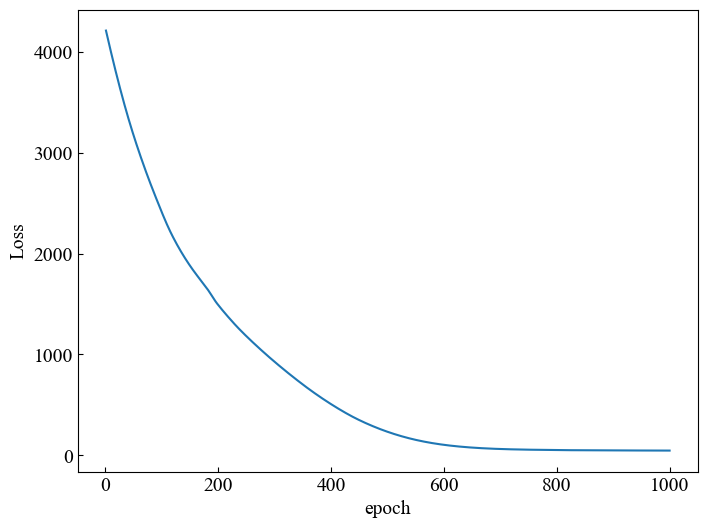

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams['font.family'] = 'Times New Roman'  # 设置全局字体为 Times New Roman
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'stix'  # 使用 STIX 字体渲染 LaTeX 数学公式
ax.plot(range(1,epoch+1), losses)

# 设置 x 轴和 y 轴的刻度朝向内
ax.tick_params(axis='both', direction='in')
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')

In [55]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# X = scalar.fit_transform(X)
# X = torch.FloatTensor(X)
model_pt.eval()  # 
with torch.no_grad():  
    y1 = model_pt(train_leaves.unsqueeze(1))
    y2 = model_pt(test_leaves.unsqueeze(1))
# y1= model_pt(X_new)
train_1_r2 = mean_squared_error(y_new.detach().numpy(),y1.detach().numpy(),squared = False)
# y2_new = (y2>=0).long()
train_1_c = r2_score(y_new.detach().numpy(),y1.detach().numpy())
train_1_mae = mean_absolute_error(y_new.detach().numpy(),y1.detach().numpy())
print(f"{train_1_r2} , {train_1_c}, {train_1_mae} ")

train_2_r2 = mean_squared_error(y_val.detach().numpy(),y2.detach().numpy(), squared = False)
# y2_new = (y2>=0).long()
train_2_c = r2_score(y_val.detach().numpy(),y2.detach().numpy())
train_2_mae = mean_absolute_error(y_val.detach().numpy(),y2.detach().numpy())
print(f"{train_2_r2} , {train_2_c},  {train_2_mae}")

0.03174203261733055 , 0.9788861870765686, 0.02126353234052658 
0.039135806262493134 , 0.966679036617279,  0.023879552260041237


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


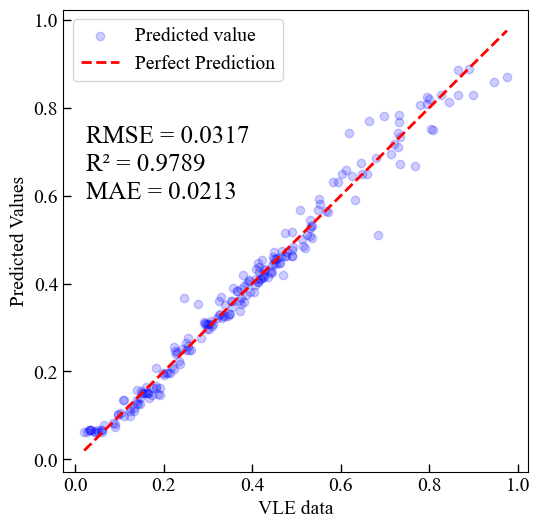

In [56]:
y_total_1 = y_new
y_pred = y1.detach().numpy()
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.family'] = 'Times New Roman'  # 设置全局字体为 Times New Roman
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'stix'  # 使用 STIX 字体渲染 LaTeX 数学公式
ax.scatter(x=y_total_1, y=y_pred, color='blue',alpha=0.2,label = "Predicted value")
ax.plot([y_total_1.min(), y_total_1.max()], [y_total_1.min(), y_total_1.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('VLE data')
ax.set_ylabel('Predicted Values')
rmse = train_1_r2
r2 = train_1_c
mae = train_1_mae
textstr = f'RMSE = {rmse:.4f}\nR² = {r2:.4f}\nMAE = {mae:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# 将文本框放置在图的右上角
ax.text(0.05, 0.75, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top')
# plt.title('True Values vs Predicted Values with Regression Line')
ax.tick_params(axis='both', direction='in', length=6, width=1)
ax.legend()

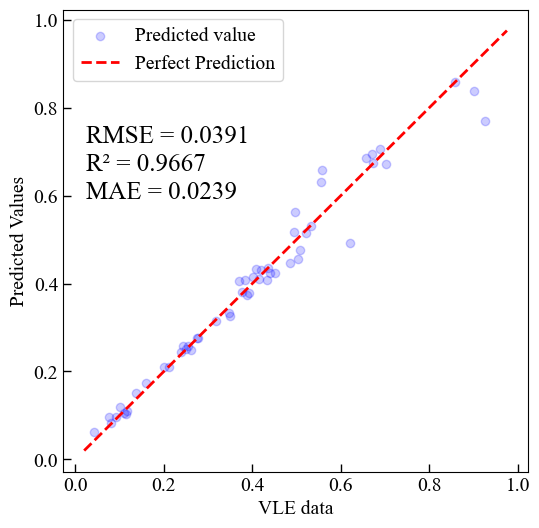

In [57]:
y_total_2 = y_val
y_pred_2 = y2.detach().numpy()
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.family'] = 'Times New Roman'  # 设置全局字体为 Times New Roman
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'stix'  # 使用 STIX 字体渲染 LaTeX 数学公式
ax.scatter(x=y_total_2, y=y_pred_2, color='blue',alpha=0.2,label = "Predicted value")
ax.plot([y_total_1.min(), y_total_1.max()], [y_total_1.min(), y_total_1.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('VLE data')
ax.set_ylabel('Predicted Values')
rmse = train_2_r2
r2 = train_2_c
mae = train_2_mae
textstr = f'RMSE = {rmse:.4f}\nR² = {r2:.4f}\nMAE = {mae:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# 将文本框放置在图的右上角
ax.text(0.05, 0.75, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top')
# plt.title('True Values vs Predicted Values with Regression Line')
ax.tick_params(axis='both', direction='in', length=6, width=1)
ax.legend()

In [58]:
#save the model
torch.save(model_pt,'complete_model_28_24_24.pth')

In [59]:
import time 
start_pinn = time.time()
# time_y1 = model_pt(train_leaves.unsqueeze(1))
# time_y2 = model_pt(test_leaves.unsqueeze(1))
all_data = xgb_reg.predict(X)
y1_pinn = torch.FloatTensor(all_data)
time_y1 = model_pt(y1_pinn.unsqueeze(1))
end_pinn = time.time()
run_time = end_pinn - start_pinn
print(f"run_time = {run_time}")

run_time = 0.0019998550415039062


In [61]:
results_df = pd.DataFrame(X)
results_df['y_pred'] = time_y1.detach().numpy()
results_df['y_exp'] = df['y_exp']

# 写入 CSV 文件
results_df.to_csv('XGB_PINN_predictions.csv', index=False)

In [62]:
loaded_model = torch.load('complete_model_28_24_24.pth')
loaded_model.eval()

C:\Users\USER\AppData\Local\Temp\ipykernel_3940\2426655433.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('complete_model_28_24_24.pth')


MultiOutputModel_3(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=24, bias=True)
    (5): ReLU()
  )
  (regression_output): Linear(in_features=24, out_features=1, bias=True)
)

In [ ]:
loaded_model(y1_pinn.unsqueeze(1))